In [390]:
import aiohttp
import asyncio
import json
import socket
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio
nest_asyncio.apply()
# %matplotlib widget
import matplotlib.pyplot as plt


In [391]:
session = aiohttp.ClientSession()

def scan_ip(ip):
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.settimeout(1)
            s.connect((ip, 80))
            return ip
    except:
        return None

def get_online_ips():
    online_ips = []
    with ThreadPoolExecutor(max_workers=256) as executor:
        futures = []
        for i in range(2, 256):
            ip = f"192.168.8.{i}"
            futures.append(executor.submit(scan_ip, ip))
        for future in futures:
            result = future.result()
            if result:
                online_ips.append(result)
    return online_ips

async def call_get(url):
    try:
        async with session.get(url, timeout=5) as response:  # 设置了5秒的超时
            return url, await response.text(), response.status
    except Exception as e:
        return url, str(e), None

async def get_hosts_status(ips):
    tasks = []
    for i in ips:
        url = f"http://" + i + "/?status"
        tasks.append(call_get(url))
    
    results = await asyncio.gather(*tasks)

    online_robots = []
    for url, content, status in results:
        if status and "html" not in content and "HTML" not in content and content != "":
            online_robots.append(json.loads(content))

    return online_robots

def get_online_robots():
    online_robots = get_online_ips()
    return asyncio.run(get_hosts_status(online_robots))

def refesh_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?status"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def calibrate_robot(robot, M1:bool, M2:bool):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?calibrate={int(M1)}{int(M2)}"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def pid_robot(robot, Kp: float, Ki: float, Kd: float, vKp: float, vKi: float, vKd: float):
    pid_parms_json = json.dumps({"Kp": Kp, "Ki": Ki, "Kd": Kd, "vKp": vKp, "vKi": vKi, "vKd": vKd})
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?pid=`{pid_parms_json}`"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def set_robot(robot, M1_trajectory_function_parms: list, M2_trajectory_function_parms: list, totalTime: int):
    assert len(M1_trajectory_function_parms) > 0 and len(M2_trajectory_function_parms) > 0, "M1_trajectory_function_parms and M2_trajectory_function_parms should not be empty"
    assert all([len(i) == 6 for i in M1_trajectory_function_parms]) and all([len(i) == 6 for i in M2_trajectory_function_parms]), "M1_trajectory_function_parms and M2_trajectory_function_parms should have 6 elements in each sub-array"
    trajectory_function_parms_json = json.dumps({"M1_trajectory": M1_trajectory_function_parms, "M2_trajectory": M2_trajectory_function_parms, "totalTime": totalTime})
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?set=`{trajectory_function_parms_json}`"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def run_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?run"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def pause_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?pause"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def resume_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?resume"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def stop_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?stop"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def get_power_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?power"))
    if status and "html" not in content:
        raw_json = json.loads(content)
        raw_power_data = raw_json['power']
        int_power_data = [int(raw_power_data[i:i+4], 16) for i in range(0, len(raw_power_data), 4)]
        result_data = []
        for i in range(0, len(int_power_data), 6):
            bus_bus = float(int_power_data[i] >> 3) * 0.008
            top_bus = float(int_power_data[i+1] >> 3) * 0.008
            bot_bus = float(int_power_data[i+2] >> 3) * 0.008
            bus_shunt = float(int_power_data[i+3] >> 3) * 0.00004
            top_shunt = float(int_power_data[i+4] >> 3) * 0.00004
            bot_shunt = float(int_power_data[i+5] >> 3) * 0.00004
            bus_current = bus_shunt / 0.02
            top_current = top_shunt / 0.04
            bot_current = bot_shunt / 0.04
            result_data.append({
                "BUS_V": bus_bus,
                "TOP_V": top_bus,
                "BOT_V": bot_bus,
                "BUS_C": bus_current,
                "TOP_C": top_current,
                "BOT_C": bot_current,
            })
        return result_data
    else:
        return None


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x113b81ed0>


In [394]:
robots = get_online_robots()
print(robots)
print(len(robots))

[{'status': 'ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': 0, 'm2_current': 0, 'm1_target': 0, 'm2_target': 0, 'm1_power': 0, 'm2_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.28, 'pause': False}]
1


In [395]:
robot = robots[0]
print(refesh_robot(robot))

{'status': 'ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': 0, 'm2_current': 0, 'm1_target': 0, 'm2_target': 0, 'm1_power': 0, 'm2_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 0.11, 'pause': False}


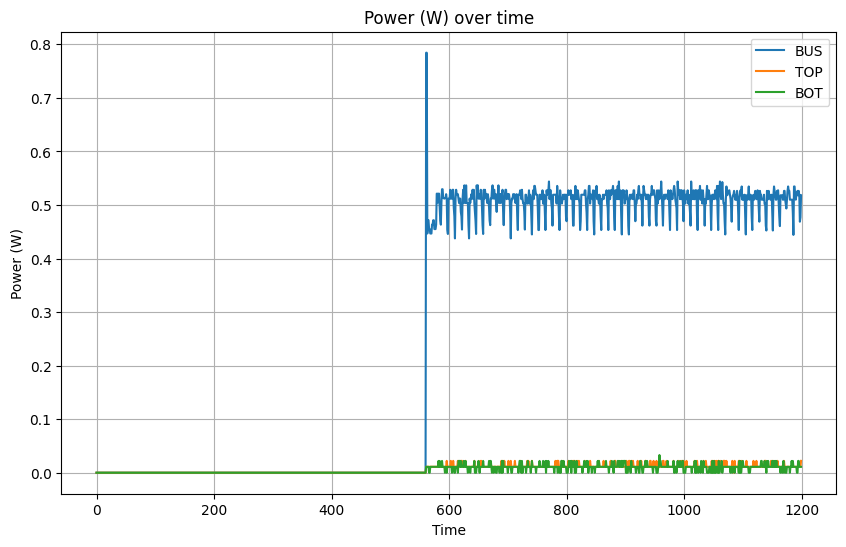

In [149]:
robot = robots[0]
data = get_power_robot(robot)

# 计算功率 (W)
bus_w = [item['BUS_V'] * item['BUS_C'] for item in data]
top_w = [item['TOP_V'] * item['TOP_C'] for item in data]
bot_w = [item['BOT_V'] * item['BOT_C'] for item in data]

# 创建x轴数据点
x = range(len(data))

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(x, bus_w, label='BUS')
plt.plot(x, top_w, label='TOP')
plt.plot(x, bot_w, label='BOT')

plt.title('Power (W) over time')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()

In [109]:
# print(pid_robot(robot, 6.6, 0.0, 0.0, 0.02, 0.0, 0.0)) # 3000
# print(pid_robot(robot, 8.0, 0.0, 0.0, 0.035, 0.04, 0.0005)) # 1000 = 2000/5000
# print(pid_robot(robot, 8.0, 3.0, 0.05, 0.018, 0.0005, 0.0001)) # -1
# print(pid_robot(robot, 12.0, 2.6, 0.05, 0.018, 0.0005, 0.0001)) # -1.5
# print(pid_robot(robot, 12.0, 3.6, 0.05, 0.018, 0.0005, 0.0001)) # -2
# print(pid_robot(robot, 14.0, 3.0, 0.05, 0.021, 0.0005, 0.0001)) # -3
# print(pid_robot(robot, 18.0, 2.0, 0.05, 0.024, 0.0005, 0.0001)) # -4
# print(pid_robot(robot, 19.0, 1.0, 0.05, 0.025, 0.0005, 0.0001)) # -5
# print(pid_robot(robot, 22.0, 0.8, 0.05, 0.025, 0.0005, 0.0001)) # -6
# print(pid_robot(robot, 22.0, 0.6, 0.05, 0.025, 0.0005, 0.0001)) # -7
print(pid_robot(robot, 25.0, 0.1, 0.01, 0.04, 0.0005, 0.0001)) # -10
# print(pid_robot(robot, 14, 6.0, 0.01, 0.025, 0.01, 0.0001)) # +

{'status': 'pid ok', 'ip': '192.168.8.222', 'mac': 'D8:3B:DA:C3:B4:34', 'm1_current': 0, 'm2_current': 0, 'm1_target': 0, 'm2_target': 0, 'm1_power': 0, 'm2_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 0.26, 'pause': False}


In [404]:
print(set_robot(robot, 
                [
                    [2300, 2, 0, 0, 255, 200],
                ], 
                [
                    [2300, 2, 0, 0, 255, 600],
                ]
                , 2000))
# totalTime = -1 means repeat forever; 5000 means at most run 5000ms
print(run_robot(robot))

{'status': 'set ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': 398, 'm2_current': 614, 'm1_target': 0, 'm2_target': 0, 'm1_power': 0, 'm2_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 0.11, 'pause': False}
{'status': 'run ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': 398, 'm2_current': 614, 'm1_target': 0, 'm2_target': 0, 'm1_power': 0, 'm2_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 0.09, 'pause': False}


In [418]:
## COT !!! TEST COT!!!!!

import time
import json
from datetime import datetime

power_data = get_power_robot(robot)

filename = "Dolphin_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".json"

# Save the Python object to a JSON file
with open(filename, "w") as json_file:
    json.dump(power_data, json_file, indent=4)

print(f"Data has been saved to {filename}")


Data has been saved to Dolphin_20241028_184835.json


In [407]:
print(calibrate_robot(robot, True, True))

{'status': 'calibrate ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': 0, 'm2_current': 0, 'm1_target': 0, 'm2_target': 0, 'm1_power': 0, 'm2_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 0.1, 'pause': False}


In [412]:
# for the white head
print(set_robot(robot, 
                [
                    [300, 2, 0, 0, 255, -1400],
                    [600, 2, 0, 0, 250, 200], 
                ], 
                [
                    [300, 2, 0, 0, 250, 200], #150
                    [600, 2, 0, 0, 255, -1200],
                ]
                , -1))
# totalTime = -1 means repeat forever; 5000 means at most run 5000ms

{'status': 'set ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': -155, 'm2_current': -919, 'm1_target': -1400, 'm2_target': 200, 'm1_power': 32, 'm2_power': 32, 'm1_error': 0, 'm2_error': 0, 'battery': 0.09, 'pause': True}


In [413]:
# time.sleep(15)
print(run_robot(robot))

{'status': 'run ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': -155, 'm2_current': -919, 'm1_target': -1400, 'm2_target': 200, 'm1_power': 64, 'm2_power': 64, 'm1_error': 0, 'm2_error': 0, 'battery': 0.09, 'pause': False}


In [417]:
print(pause_robot(robot))

{'status': 'resume ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': 38, 'm2_current': -1006, 'm1_target': -1400, 'm2_target': 200, 'm1_power': 32, 'm2_power': 32, 'm1_error': 0, 'm2_error': 0, 'battery': 0.07, 'pause': True}


In [416]:
print(resume_robot(robot))

{'status': 'pause ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': 340, 'm2_current': -510, 'm1_target': -1400, 'm2_target': 200, 'm1_power': 32, 'm2_power': 32, 'm1_error': 0, 'm2_error': 0, 'battery': 0.07, 'pause': False}


In [305]:
print(stop_robot(robot))

{'status': 'stop ok', 'ip': '192.168.8.219', 'mac': 'D8:3B:DA:C3:B3:F8', 'm1_current': -601, 'm2_current': 499, 'm1_target': 200, 'm2_target': -1200, 'm1_power': 32, 'm2_power': 32, 'm1_error': 0, 'm2_error': 0, 'battery': 0.04, 'pause': False}


In [ ]:
import time
print(refesh_robot(robot))
time.sleep(1)
print(refesh_robot(robot))

In [ ]:
# for the white head
print(set_robot(robot, 
                [
                    [300, 2, 0, 0, 255, -1400],
                    [600, 2, 0, 0, 150, 200], 
                    # sin(ax + b) * c + d
                    # [10000, 1, 3.14159/5000, 2500, 3000, 3000],
                    # ax^3 + bx^2 + cx + d
                    # [5000, 0, 0, 0, 0, -6000],
                    # [1000, 0, 0, 0, -10, 0],
                    # [5000, 0, 0, 0, 0, -10000],
                    # [6000, 0, 0, 0, 10, -60000],
                    # [10000, 0, 0, 0, 0, 0],
                ], 
                [
                    [300, 2, 0, 0, 150, 200], #150
                    [600, 2, 0, 0, 255, -1200],
                    # [1, 1, 3.14159/5000, 0, 3000, 0],
                    # [10000, 0, 0, 0, 0, 0],
                    # [15000, 0, 0, 0, -1, 0],
                    # [20000, 0, 0, 0, 0, 0],
                    # [5000, 0, 0, 0, 1, 0],
                    # [10000, 0, 0, 0, 0, 5000],
                    # [15000, 0, 0, 0, -1, 15000],
                    # [20000, 0, 0, 0, 0, 0],
                ]
                , -1))
# totalTime = -1 means repeat forever; 5000 means at most run 5000ms